In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
%matplotlib inline
from wavenet import wavenetSC
                

In [2]:
f = 5
d = f*51
np.random.seed(42)
pi = np.random.permutation(d).reshape(f,51)
pi


array([[190,   6,  79, 205, 117, 185, 201, 167,   9,  30, 180, 221, 229,
        216, 136,  68, 198,  15,  96,  24, 234,  19, 120, 152,  33, 124,
        252, 243,  10, 164, 184,  97, 148, 209, 222,  25,  86,  18,  75,
        137, 195, 176, 238, 181,  45,  66,  16,  67, 206, 200, 177],
       [ 38, 143,  84,  55, 219, 104, 139, 127,  60, 101, 172, 248, 126,
        224, 144, 108, 178,  73, 114, 158,  69, 141, 109, 115, 245, 113,
        242,  90,  29, 170,  82, 111,   5,  56, 132, 154, 162,  65, 186,
         85, 217, 236,  31,  12,  35,  28,  42, 112,  22, 125,  93],
       [173, 250,  51, 239,  95, 146, 223,  76,  41, 119, 155,  78, 150,
         26, 246, 168, 118, 192, 140,   0,   2,  77,  46, 100, 204, 159,
        183, 253,  98,  36,  61, 199, 142,  11, 249, 241,  27, 230,   4,
        122,  32, 147, 182, 138,  62, 135, 128, 231, 193,  70, 196],
       [ 64,  44, 165, 156,  40, 123, 153,  23, 227, 215,  81,  39, 213,
         47,  94, 194, 161,  43, 145, 175,   3, 105,  53, 133, 

In [3]:
def generate_signal(fingers, pi, sig=0):
    d = np.prod(pi.shape)+1
    z = np.random.uniform(size=d)
    x = sig*np.random.normal(size=d)
    for f in fingers:
        x[pi[f]] = z[pi[f]]
    return x

def generate_data(n, pi, sig=0, p=np.ones(7)/7):
    d = np.prod(pi.shape)+1
    X = np.zeros(n*d).reshape(n,d)
    y = [0]*n
    for s in np.arange(n):
        this_y = np.random.choice(np.arange(7), p=p)
        if this_y < 5:
            X[s] = generate_signal([this_y], pi, sig)
        elif this_y == 5:
            X[s] = generate_signal([0,1], pi, sig)
        elif this_y == 6:
            X[s] = generate_signal([0,2], pi, sig)
        y[s] = this_y
    y = np.array(y)
    return X, y

def viz_data_point(x, y, pi):
    d = len(x)
    z = np.zeros(d)
    if y < 5:
        z[pi[y]] = -.2
    elif y == 5:
        z[pi[0]] = -.2
        z[pi[1]] = -.2
    elif y == 6:
        z[pi[0]] = -.2
        z[pi[2]] = -.2
    plt.bar(np.arange(d), height=x)
    plt.bar(np.arange(d), height=z)

In [4]:
n = 1000
p0 = 0.16
p = [p0, p0, p0, p0, p0, (1-5*p0)/2, (1-5*p0)/2]
X, y = generate_data(n, pi, sig=.3, p=p)
X_test, y_test = generate_data(n, pi, sig=.3, p=p)
p

[0.16, 0.16, 0.16, 0.16, 0.16, 0.09999999999999998, 0.09999999999999998]

5

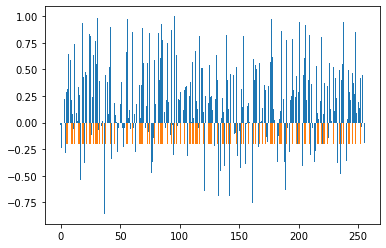

In [5]:
s = np.random.choice(np.arange(n))
this_x = X[s]
this_y = y[s]
viz_data_point(this_x, this_y, pi)
this_y

In [6]:
X.shape
K = len(set(y))

In [7]:
wnsc = wavenetSC(num_inputs=X.shape[1], num_outputs=K, num_units=1600, batch_size=128, lmda=.002,
            lr_r=0.025, lr_W1=0.020, r1=5, r2=7, wi=5, we=20, sigmaE=4, target_sparsity=.3)


In [8]:
l2_loss, l1_loss, l0_loss, steps = wnsc.train(X, gradient_steps=4000)

loss=12.762 sparsity=29.44% steps=14 lmda=0.009: 100%|██████████| 4000/4000 [38:58<00:00,  1.71it/s]


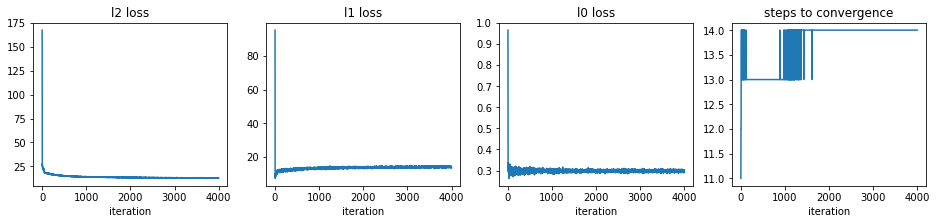

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,3))
ax1.plot(np.arange(len(l2_loss)), l2_loss)
ax1.set_xlabel('iteration')
ax1.set_ylabel('')
ax1.set_title('l2 loss')
ax2.plot(np.arange(len(l1_loss)), l1_loss)
ax2.set_xlabel('iteration')
ax2.set_ylabel('')
_ = ax2.set_title('l1 loss')
ax3.plot(np.arange(len(l0_loss)), l0_loss)
ax3.set_xlabel('iteration')
ax3.set_ylabel('')
_ = ax3.set_title('l0 loss')
ax4.plot(np.arange(len(steps)), steps)
ax4.set_xlabel('iteration')
ax4.set_ylabel('')
_ = ax4.set_title('steps to convergence')


In [10]:
inds = np.random.randint(0, X.shape[0], wnsc.batch_size)
batch = X[inds, :]
a, s = wnsc.compute_activations(X)
print('steps=%d' % s)

steps=14


In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def map_for_label(lbl, cmap='jet', interpolation='gaussian'):
    inds = np.arange(X.shape[0])[y==lbl]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
    amean = np.mean(a[inds,:], axis=0).reshape(40, 40)

    im1 = ax1.imshow(amean, cmap='jet', interpolation='gaussian', vmin=-.125,vmax=.125)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size ="5%", pad=0.1)
    fig.colorbar(im1, cax=cax)    
    ax1.axis('off')
    
    im2 = ax2.imshow(a[np.random.choice(inds)].reshape(40,40), cmap=cmap, interpolation=interpolation)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size ="5%", pad=0.1)
    fig.colorbar(im2, cax=cax)
    ax2.axis('off')

    im3 = ax3.imshow(np.std(a[inds,:], axis=0).reshape(40, 40), cmap=cmap, interpolation=interpolation)
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size ="5%", pad=0.1)
    fig.colorbar(im3, cax=cax)    
    ax3.axis('off')
    #fig.savefig('map_lbl_%d.pdf' % lbl, bbox_inches='tight')



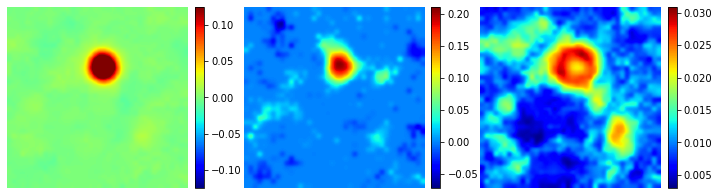

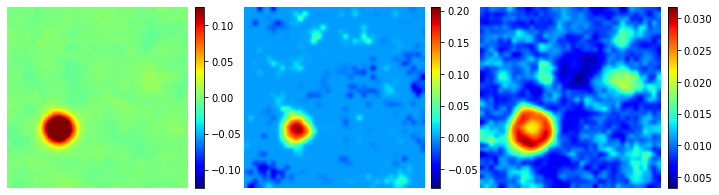

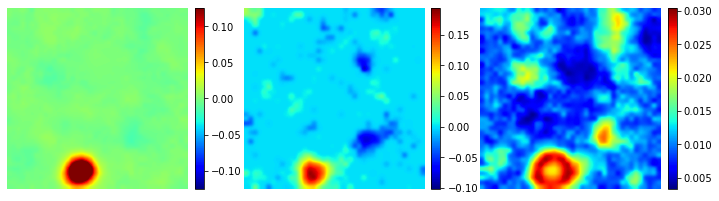

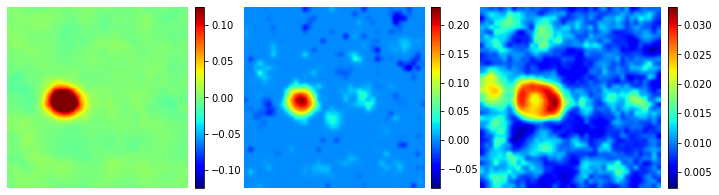

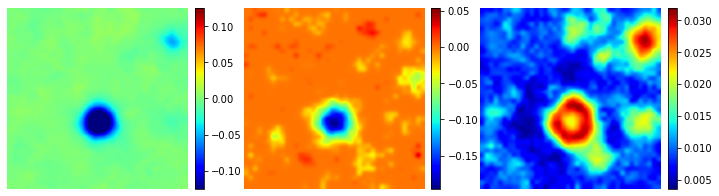

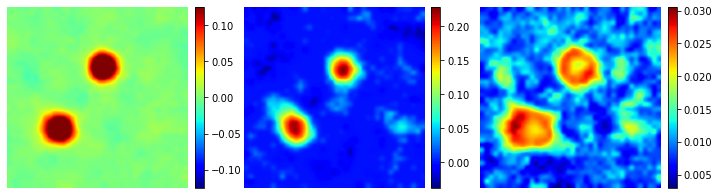

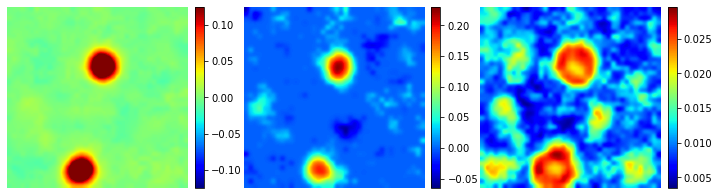

In [12]:
for lbl in np.arange(7):
    map_for_label(lbl) 

(-0.5, 39.5, 39.5, -0.5)

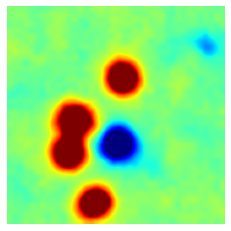

In [13]:
amean = 0*np.mean(a, axis=0).reshape(40, 40)
for l in np.arange(5):
    inds = np.arange(X.shape[0])[y==l]
    amean = amean + np.mean(a[inds,:], axis=0).reshape(40, 40)
plt.imshow(amean, cmap='jet', interpolation='gaussian', vmin=-.125, vmax=.125)
plt.axis('off')


In [14]:
valid = set(np.arange(7)).difference(set([2,6]))
inds = [i for i in np.arange(X.shape[0]) if y[i] in valid]
X_restricted = X[inds]
y_restricted = y[inds]

In [15]:
l2_loss_r, l1_loss_r, l0_loss_r, steps_r = wnsc.train(X_restricted, gradient_steps=3000)

loss=11.175 sparsity=29.73% steps=14 lmda=0.009: 100%|██████████| 3000/3000 [29:23<00:00,  1.70it/s]


In [16]:
l2_loss = l2_loss + l2_loss_r
l1_loss = l1_loss + l1_loss_r
l0_loss = l0_loss + l0_loss_r
steps = steps + steps_r


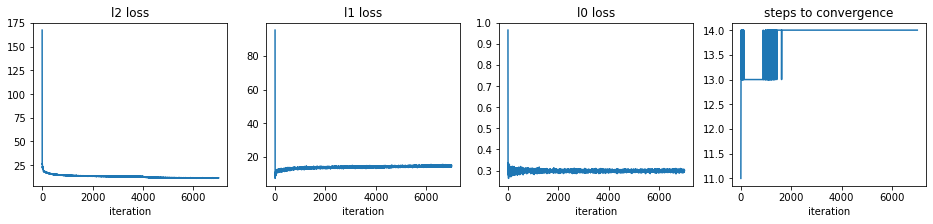

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,3))
ax1.plot(np.arange(len(l2_loss)), l2_loss)
ax1.set_xlabel('iteration')
ax1.set_ylabel('')
ax1.set_title('l2 loss')
ax2.plot(np.arange(len(l1_loss)), l1_loss)
ax2.set_xlabel('iteration')
ax2.set_ylabel('')
_ = ax2.set_title('l1 loss')
ax3.plot(np.arange(len(l0_loss)), l0_loss)
ax3.set_xlabel('iteration')
ax3.set_ylabel('')
_ = ax3.set_title('l0 loss')
ax4.plot(np.arange(len(steps)), steps)
ax4.set_xlabel('iteration')
ax4.set_ylabel('')
_ = ax4.set_title('steps to convergence')

In [18]:
inds = np.random.randint(0, X.shape[0], wnsc.batch_size)
batch = X[inds, :]
a, s = wnsc.compute_activations(X)
print('steps=%d' % s)

steps=14


(-0.5, 39.5, 39.5, -0.5)

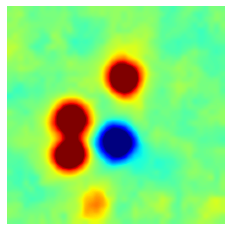

In [19]:
amean = 0*np.mean(a, axis=0).reshape(40, 40)
for l in np.arange(5):
    inds = np.arange(X.shape[0])[y==l]
    amean = amean + np.mean(a[inds,:], axis=0).reshape(40, 40)
plt.imshow(amean, cmap='jet', interpolation='gaussian', vmin=-.125, vmax=.125)
plt.axis('off')